In [1]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook

matplotlib.rc('font', weight='bold', size=22)

import pandas as pd
import numpy as np

from coind.tickers import streamable, stream_tickers, ticker_sample, stream_batches, batch_sample

In [2]:
ticker_logs = (
    './data/stream.longer.3.log',
)

In [3]:
streamable_products = streamable(*ticker_logs)
len(streamable_products), streamable_products

(17,
 ['XRP-USD',
  'BTC-USD',
  'BTC-GBP',
  'LTC-USD',
  'ETH-BTC',
  'ETC-BTC',
  'BCH-BTC',
  'BTC-EUR',
  'BCH-USD',
  'ETH-EUR',
  'ETH-USD',
  'ETC-USD',
  'LTC-BTC',
  'ZRX-USD',
  'BAT-USDC',
  'XLM-USD',
  'ZRX-BTC'])

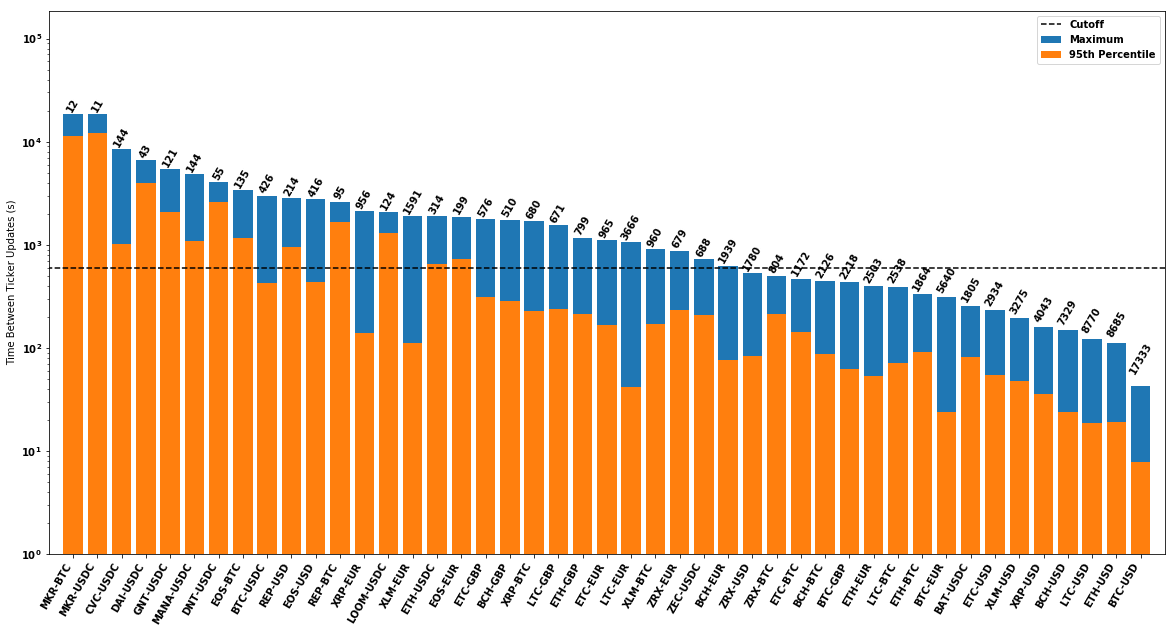

In [4]:
df = pd.DataFrame.from_records(list(stream_tickers(*ticker_logs)),
                               columns=ticker_sample._fields)


cutoff = 600
percentile = 95


deltas = {}
for product in df.product_id.unique():
    product_df = df[df.product_id == product]    
    x = product_df.time
    dts = [(x.iloc[j] - x.iloc[j - 1]).total_seconds() for j in range(1, len(x))]
    deltas[product] = dts
products, deltas = zip(*sorted(deltas.items(), key=(lambda dt: max(dt[1])), reverse=True))


f, ax = plt.subplots(1, 1, figsize=(20, 10))

x = np.arange(len(deltas)) + 0.5
maximums = [max(dts) for dts in deltas]
ax.bar(x, maximums, label='Maximum')
for rect, label in zip(ax.patches, [f'{len(y)}' for y in deltas]):
    ax.text(rect.get_x() + rect.get_width() / 2, rect.get_height() + 10, label,
            ha='center', va='bottom', rotation=60)
percentiles = [np.percentile(dts, percentile) for dts in deltas]
ax.bar(x, percentiles, label=f'{percentile}th Percentile', width=0.8)

ax.set_xlim((x.min() - 1, x.max() + 1))
ax.set_xticks(x)
ax.set_xticklabels(products, rotation=60, ha='right')
ax.set_ylabel('Time Between Ticker Updates (s)')
ax.set_yscale('log')
ax.set_ylim((1, 10 * max(maximums)))

ax.plot((-10, 100), (cutoff, cutoff), color='k', ls='--', label='Cutoff')
ax.legend()

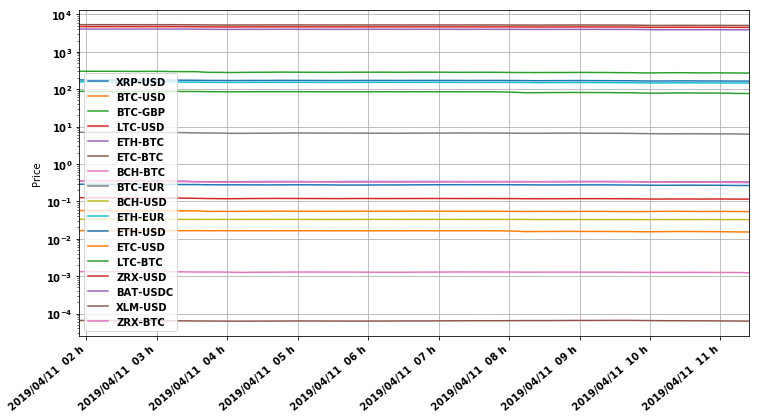

In [5]:
stream = stream_tickers(*ticker_logs, products=streamable_products)
df = pd.DataFrame.from_records(stream_batches(stream, products=streamable_products),
                               columns=batch_sample._fields)


f, ax = plt.subplots(1, 1, figsize=(12, 6))
for product in streamable_products:
    ax.plot(df.time, df.prices.apply(lambda ps: ps[product]), label=product)
ax.xaxis.set_major_locator(mdates.HourLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y/%m/%d  %H h"))
ax.set_xlim((df.time.min(), df.time.max()))
for tick in ax.get_xticklabels():
    tick.set_rotation(40)
    tick.set_ha('right')
ax.grid(True)
ax.set_ylabel('Price')
ax.set_yscale('log')
ax.legend()